# Important Cities

@roman

24 June, 2024

Code to get the polygons with relative high density in order to find the important cities in the database

---
# Settings

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import uuid
import h3
import os

from INEGIpy import MarcoGeoestadistico

from sklearn.cluster import DBSCAN
from scipy.spatial import KDTree

In [2]:
# Settings
# show 100 columns in pandas
pd.set_option('display.max_columns', 100)
geo_framework = MarcoGeoestadistico()

---
# Data

## Properties

In [3]:
# read parquet
gdf_properties = pd.read_parquet("../../data/interim/cleaned_data_s3.parquet")

# get original columns
original_columns = gdf_properties.columns

# see num of rows
gdf_properties.shape

(935593, 41)

In [80]:
# see cols
original_columns

Index(['property_id', 'valor_fisico_construccion', 'property_id', 'valuation_date',
       'neighborhood', 'id_clase_inmueble', 'id_tipo_inmueble', 'conservacion',
       'elevador', 'niveles', 'cve_ref_proximidad_urbana',
       'cve_nivel_equipamiento_urbano', 'valor_mercado',
       'price', 'nivel', 'unidades_rentables', 'edad_anios',
       'precio_m2', 'vida_util_remanente', 'cve_clasificacion_zona',
       'cve_vigilancia', 'regimen_propiedad', 'tipo_vialidad', 'id_uv',
       'municipality_id', 'state_id', 'clave_controlador', 'clave_valuador',
       'id_otorgante', 'cp', 'latitude', 'longitude', 'recamaras', 'banos',
       'medio_banos', 'estacionamiento', 'superficie_terreno',
       'superficie_construida', 'superficie_accesoria', 'saleable_area',
       'land_price_per_sqm'],
      dtype='object')

In [4]:
# geodataframe
gdf_properties = (
    gpd.GeoDataFrame(
        gdf_properties,
        geometry=gpd.points_from_xy(gdf_properties['longitude'], gdf_properties['latitude']),
        crs='EPSG:4326'
    )
    .drop(columns=['latitude', 'longitude'])
)

gdf_properties.head()

property_id  valor_fisico_construccion  \
0  db1200620f5445728461a6038f3c54cf                 1035475.65   
1  6ccb6aabf3704d7fb9befc214a4c786b                  491898.00   
2  66cf10199ef943a5a5ff82129e53d5d7                 1611371.52   
3  3e1c9d1d15e648668c35cb0238e0f68c                  697726.22   
4  f84f9a0c784f491eab6bb100b513a95b                  460588.28   

           property_id valuation_date neighborhood  id_clase_inmueble  \
0   9067200711805890   2020-04-27      SD                  4   
1   9067200311678970   2020-01-20      SD                  4   
2  090682009R0225150   2020-05-27      SD                  4   
3  090832021R0653330   2020-12-08      SD                  3   
4  090682015R0258032   2020-07-23      SD                  3   

   id_tipo_inmueble  conservacion  elevador  niveles  \
0                 2           4.0       0.0        1   
1                 2           4.0       0.0        1   
2                 2           4.0       1.0        4   
3                 2           4.0       2.0        2   
4                 2           4.0       2.0        3   

   cve_ref_proximidad_urbana  cve_nivel_equipamiento_urbano  valor_mercado  \
0                          5                              1        1841577   
1                          5                              1        1393971   
2                          1                              1        4305275   
3                          2                              1         826000   
4                          2                              1        1351682   

   price  nivel unidades_rentables  edad_anios  precio_m2  \
0                1842000      3                  2          15      11091   
1                1394000      3                  1           9      18703   
2                4305000      3                  1          25      12353   
3                 829000      3                  1          20       5954   
4                1352000      3                  1          25      12482   

   vida_util_remanente  cve_clasificacion_zona  cve_vigilancia  \
0                   55                       3             1.0   
1                   61                       3             1.0   
2                   45                       4             NaN   
3                   40                       3             NaN   
4                   35                       3             NaN   

    regimen_propiedad  tipo_vialidad  id_uv municipality_id state_id  \
0  PRIVADA INDIVIDUAL            3.0   9067          107           07   
1  PRIVADA INDIVIDUAL            2.0   9067          008           03   
2  PRIVADA INDIVIDUAL            NaN   9068          003           09   
3  PRIVADA INDIVIDUAL            NaN   9083          051           21   
4  PRIVADA INDIVIDUAL            NaN   9068          058           15   

   clave_controlador  clave_valuador id_otorgante     cp  recamaras  banos  \
0            1844523          408526        40012  30535          3      1   
1             408047         1641235        40012  23570          1      1   
2            1742315         1400027        30001   4600          2      1   
3            1844210         1639485        30001  74585          4      2   
4            1742315         1400027        30001  57100          2      2   

   medio_banos  estacionamiento  superficie_terreno  superficie_construida  \
0            0                3                 620                    166   
1            0                2                 561                     74   
2            0                0                 143                    348   
3            1                0                  93                    139   
4            0                1                 113                    108   

   superficie_accesoria  saleable_area  land_price_per_sqm  \
0                     0                  166                   1142.0   
1                     0                   74                   1278.9   

## Inegi

In [5]:
# get all mexico states
gdf_mex_states = geo_framework.Entidades()
gdf_mex_states.head()

geometry cvegeo cve_agee  \
0  MULTIPOLYGON (((-102.29739 22.45527, -102.2955...     01       01   
1  MULTIPOLYGON (((-114.11561 28.09639, -114.1152...     02       02   
2  MULTIPOLYGON (((-109.89451 22.87476, -109.8946...     03       03   
3  MULTIPOLYGON (((-91.95650 20.19700, -91.95636 ...     04       04   
4  MULTIPOLYGON (((-102.31549 29.88000, -102.3150...     05       05   

               nom_agee nom_abrev      pob  pob_fem  pob_mas      viv  
0        Aguascalientes      Ags.  1425607   728924   696683   386671  
1       Baja California        BC  3769020  1868431  1900589  1149563  
2   Baja California Sur       BCS   798447   392568   405879   240660  
3              Campeche     Camp.   928363   471424   456939   260824  
4  Coahuila de Zaragoza     Coah.  3146771  1583102  1563669   901249

<Axes: >

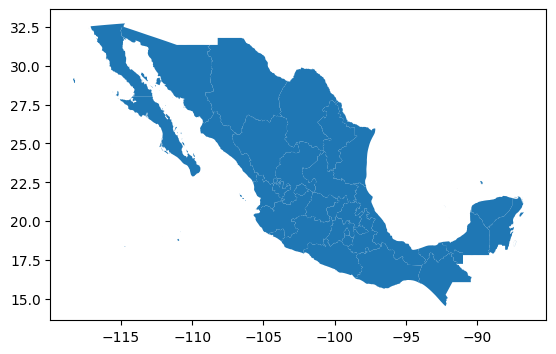

In [6]:
# plot states
gdf_mex_states.plot()

---
# Geographical Clustering

## S1: Define minimum number of points to form a cluster

In [7]:
# from crs 4326 to 6372
gdf_properties = gdf_properties.to_crs('EPSG:6372')

# get lon and lat
gdf_properties['longitude'] = gdf_properties.geometry.x
gdf_properties['latitude'] = gdf_properties.geometry.y

In [8]:
# define function to get poiunts at r distance
def get_neighbors(gdf, r):
    # fit a kdtree
    kdtree = KDTree(
        data=gdf[['longitude', 'latitude']],
    )
    # count neighbors at r-km
    gdf[f'neighbors_{r}km'] = kdtree.query_ball_point(
        gdf[['longitude', 'latitude']],
        r=r * 1_000,
        workers=-1,
        return_length=True
    )
    return gdf

# get neighbors at provided distances
list_distances = [0.1, 0.25, 0.5, 1, 2, 5]

for r in tqdm(list_distances):
    gdf_properties = get_neighbors(gdf_properties, r)

100%|██████████| 6/6 [00:22<00:00,  3.80s/it]


In [9]:
# get percentil of neighbors at N
def percentil_at_x(x, p):
    return x.gt(p).mean()

# get percentil of neighbors at N
N_MIN_NEIGHBORS = 100


In [10]:
# General
(
    gdf_properties
    .filter(like='neighbors')
    .apply(
        lambda x: percentil_at_x(x, N_MIN_NEIGHBORS)
    .sort_values()
    )
)


neighbors_0.1km     0.074562
neighbors_0.25km    0.329799
neighbors_0.5km     0.572665
neighbors_1km       0.843238
neighbors_2km       0.950125
neighbors_5km       0.978513
dtype: float64

In [11]:
# now see it at state level
(
    gdf_properties
    .groupby('state_id')
    .apply(
        lambda x: x.filter(like='neighbors').apply(
            lambda x: percentil_at_x(x, N_MIN_NEIGHBORS)
        ),
        include_groups=False
    )
    .T
    .sort_index()
    .style.format("{:.0%}")
)

^^^ it seems that 1km is the best distance to get at least 10 neighbors

## S2: Cluster Points Within M meters

In [12]:
# use dbscan to cluster
eps = 1000  # m meters of distance
min_samples = 100  # n points to consider a cluster

# get the clusters
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
gdf_properties['cluster'] = dbscan.fit_predict(gdf_properties[['longitude', 'latitude']])

In [13]:
# identify the isolated points
print("percent of isolated points", gdf_properties['cluster'].eq(-1).mean())
print("total isolated points", gdf_properties['cluster'].eq(-1).sum())

percent of isolated points 0.08748248437087494
total isolated points 81848


<Axes: >

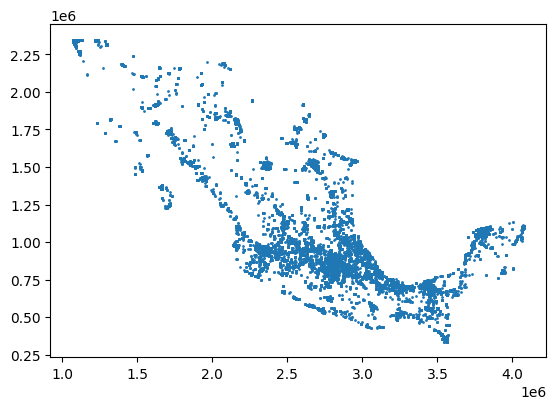

In [14]:
# plot isolated points
gdf_properties[gdf_properties['cluster'].eq(-1)].plot(markersize=1)

In [15]:
# count clusters
print("num of potential cities", gdf_properties['cluster'].nunique() - 1)  # -1 for the isolated points

num of potential cities 547


<Axes: >

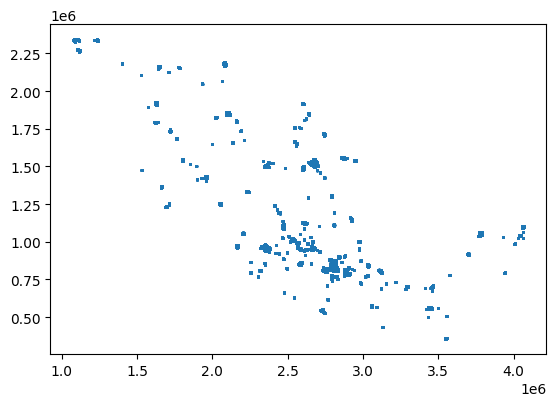

In [16]:
# plot no-isolated points
gdf_properties[gdf_properties['cluster'].ne(-1)].plot(markersize=1)

In [17]:
# subset the data
gdf_properties = gdf_properties[gdf_properties['cluster'].ne(-1)]
gdf_properties.shape

(853745, 49)

## S3: Convex Hull of each cluster

### Raw

In [18]:
# get convex hull of each cluster
gdf_cities = (
    gdf_properties
    .dissolve(by='cluster')
    .reset_index()
    .assign(
        geometry=lambda x: x['geometry'].convex_hull
    )
    .loc[:, ['cluster', 'geometry', 'state_id', 'municipality_id']]
)
gdf_cities.shape

(547, 4)

In [19]:
# convex hull of each cluster
gdf_cities.explore(
    tiles='CartoDB positron',
)

### Pooling

In [20]:
# get lat & long of each cluster
gdf_cities['longitude'] = gdf_cities['geometry'].centroid.x
gdf_cities['latitude'] = gdf_cities['geometry'].centroid.y

# use dbscan to re-cluster the cities
eps = 15_000  # m meters of distance
min_samples = 1  # n points to consider a cluster

# get the clusters
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
gdf_cities['city_cluster'] = dbscan.fit_predict(gdf_cities[['longitude', 'latitude']])

# count clusters
gdf_cities['city_cluster'].nunique()

158

In [21]:
# get convex hull of each cluster
gdf_cities2 = (
    gdf_cities
    .dissolve(by='city_cluster')
    .reset_index()
    .assign(
        geometry=lambda x: x['geometry'].convex_hull
    )
    .loc[:, ['city_cluster', 'geometry', 'state_id', 'municipality_id']]
)


# explore
gdf_cities2.explore(tiles='CartoDB positron')

In [22]:
gdf_cities2

city_cluster                                           geometry  \
0               0  POLYGON ((2802508.846 807491.784, 2789672.652 ...   
1               1  POLYGON ((1629955.271 1907389.003, 1627448.198...   
2               2  POLYGON ((3774584.424 1040369.440, 3771144.074...   
3               3  POLYGON ((1689809.795 1228251.713, 1688632.431...   
4               4  POLYGON ((2925744.121 1137557.697, 2925578.403...   
..            ...                                                ...   
153           153  POLYGON ((2465808.773 1027282.693, 2464899.188...   
154           154  POLYGON ((3766607.192 1039525.460, 3766036.237...   
155           155  POLYGON ((3155663.269 722381.567, 3154738.490 ...   
156           156  POLYGON ((1955975.906 1403742.907, 1955639.042...   
157           157  POLYGON ((1708626.947 2125704.430, 1708394.338...   

    state_id municipality_id  
0             09          003  
1             26          030  
2             31          050  
3             03          008  
4             28          003  
..           ...          ...  
153           14          073  
154           31          101  
155           30          045  
156           25          006  
157           26          019  

[158 rows x 4 columns]

## S4: Mini EDA

In [23]:
# count how many properties are in each city
table_city_counts = (
    gdf_properties
    .sjoin(
        gdf_cities2,
        how='left',
        predicate='within'
    )
    .groupby('city_cluster')
    .size()
    .reset_index()
    .rename(columns={0: 'num_properties'})
    .merge(
        gdf_cities2,
        on='city_cluster',
        how='left'
    )
)
table_city_counts

city_cluster  num_properties  \
0             0.0          119013   
1             1.0           15694   
2             2.0           20074   
3             3.0            2136   
4             4.0            8235   
..            ...             ...   
153         153.0             224   
154         154.0             336   
155         155.0              88   
156         156.0              86   
157         157.0              95   

                                              geometry state_id  \
0    POLYGON ((2802508.846 807491.784, 2789672.652 ...           09   
1    POLYGON ((1629955.271 1907389.003, 1627448.198...           26   
2    POLYGON ((3774584.424 1040369.440, 3771144.074...           31   
3    POLYGON ((1689809.795 1228251.713, 1688632.431...           03   
4    POLYGON ((2925744.121 1137557.697, 2925578.403...           28   
..                                                 ...          ...   
153  POLYGON ((2465808.773 1027282.693, 2464899.188...           14   
154  POLYGON ((3766607.192 1039525.460, 3766036.237...           31   
155  POLYGON ((3155663.269 722381.567, 3154738.490 ...           30   
156  POLYGON ((1955975.906 1403742.907, 1955639.042...           25   
157  POLYGON ((1708626.947 2125704.430, 1708394.338...           26   

    municipality_id  
0            003  
1            030  
2            050  
3            008  
4            003  
..           ...  
153          073  
154          101  
155          045  
156          006  
157          019  

[158 rows x 5 columns]

<Axes: ylabel='Frequency'>

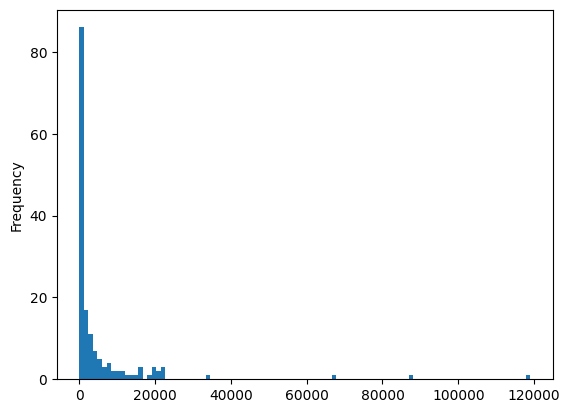

In [24]:
# num properties distribution
table_city_counts['num_properties'].plot(kind='hist', bins=100)

In [25]:
# describe
table_city_counts['num_properties'].describe()

count       158.000000
mean       5390.917722
std       13728.654051
min          86.000000
25%         291.000000
50%         875.000000
75%        4441.000000
max      119013.000000
Name: num_properties, dtype: float64

In [26]:
# to geodataframe
table_city_counts = gpd.GeoDataFrame(
    table_city_counts,
    geometry='geometry',
    crs='EPSG:4326'
)

# map
table_city_counts.explore(
    'num_properties',
    tiles='CartoDB positron',
    cmap='cividis',
    legend=True
)

## S5: Save

In [27]:
# create misc
os.makedirs("../../data/misc", exist_ok=True)
gdf_cities2.to_parquet("../../data/misc/polygons_cities_analysis.parquet")

---
# Geopsatial Pricing

## S1: Get Hexagon Grid for cities


In [28]:
# Ensure we use lat/lon coordinates
def to_latlon(gdf):
    if gdf.crs is not None and gdf.crs.to_string() != 'EPSG:4326':
        gdf = gdf.to_crs('EPSG:4326')
    return gdf

# Get all H3 hexagons covering a shapely geometry
def h3_polyfill(geometry, resolution):
    hexagons = set()
    if geometry.geom_type == 'Polygon':
        hexagons.update(h3.polyfill(geometry.__geo_interface__, resolution, geo_json_conformant=True))
    elif geometry.geom_type == 'MultiPolygon':
        for poly in geometry:
            hexagons.update(h3.polyfill(poly.__geo_interface__, resolution, geo_json_conformant=True))
    return hexagons

# Create GeoDataFrame of H3 hexagons from a set of H3 indices
def hexagons_to_geodf(hexagons, crs):
    # each hexagon to polygon
    polygons = [Polygon(h3.h3_to_geo_boundary(h, geo_json=True)) for h in hexagons]
    # create geodataframe
    gdf = gpd.GeoDataFrame(geometry=polygons, crs=crs)
    return gdf

# Vectorized function to compute hexagons
def create_hex_grid_vectorized(gdf, resolution):
    # copy
    gdf = gdf.copy()

    # buffer by 1km the geometries
    gdf = gdf.to_crs('EPSG:6372')
    gdf['geometry'] = gdf['geometry'].buffer(1_000)

    # Convert GeoDataFrame to lat/lon if not already
    gdf = to_latlon(gdf)

    # Get H3 hexagons for all geometries
    hex_sets = np.array([h3_polyfill(geom, resolution) for geom in gdf['geometry']])
    
    # Flatten the hexagon sets
    all_hexagons = set().union(*hex_sets)

    # Convert H3 indices to GeoDataFrame
    hex_gdf = hexagons_to_geodf(all_hexagons, gdf.crs)
    return hex_gdf

# Define the H3 resolution
resolution = 7

# Create the hexagon grid
hex_gdf = create_hex_grid_vectorized(gdf_cities2, resolution)
hex_gdf


geometry
0     POLYGON ((-99.05245 19.59013, -99.04375 19.601...
1     POLYGON ((-99.98716 25.58498, -99.97808 25.596...
2     POLYGON ((-100.92278 25.44335, -100.91376 25.4...
3     POLYGON ((-100.21310 25.79010, -100.20401 25.8...
4     POLYGON ((-101.46490 26.88350, -101.45581 26.8...
...                                                 ...
4477  POLYGON ((-99.18184 18.60350, -99.17321 18.614...
4478  POLYGON ((-110.96605 29.02104, -110.95761 29.0...
4479  POLYGON ((-99.19081 18.86610, -99.18217 18.877...
4480  POLYGON ((-105.97488 28.57353, -105.96599 28.5...
4481  POLYGON ((-100.80535 22.11933, -100.79656 22.1...

[4482 rows x 1 columns]

In [29]:
hex_gdf.explore(tiles='CartoDB positron')

## S2: Prices in Zones

/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


<Axes: xlabel='id_tipo_inmueble', ylabel='land_price_per_sqm'>

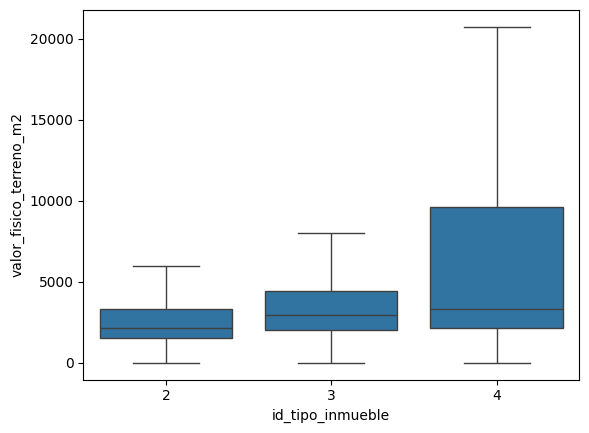

In [30]:
# plot boxplots of land_price_per_sqm by id_tipo_inmueble
# log scale
sns.boxplot(
    x='id_tipo_inmueble',
    y='land_price_per_sqm',
    data=gdf_properties,
    showfliers=False
)

## S3: Log Z-Score by City

### Join

In [46]:
# join properties to cities
gdf_properties = (
    gpd.sjoin(
        gdf_properties,
        gdf_cities2.loc[:, ['city_cluster', 'geometry']].assign(geometry=lambda x: x.buffer(10)),  # give 10m of chance
        how='left',
        predicate='within'
    )
    # drop duplicates
    .drop_duplicates(subset=['property_id'])
)
gdf_properties.shape

(853745, 52)

In [47]:
# see empties
gdf_properties['city_cluster'].isna().mean()
gdf_properties['city_cluster'].isna().sum()

0

### Get Z Scores by City

In [48]:
# get log land_price_per_sqm
gdf_properties['log_valor_fisico_terreno_m2'] = np.log(gdf_properties['land_price_per_sqm'])

In [49]:
# zscores
table_zscores_cities = (
    gdf_properties
    .groupby('city_cluster')
    .agg(
        log_terrain_mean=('log_valor_fisico_terreno_m2', 'mean'),
        log_terrain_std=('log_valor_fisico_terreno_m2', 'std'),
        num_properties=('property_id', 'count')
    )
    .sort_values('log_terrain_std')
)
table_zscores_cities

log_terrain_mean  log_terrain_std  num_properties
city_cluster                                                   
106                   7.822824         0.158905             225
139                   7.892876         0.184203             243
118                   7.665616         0.188648             529
75                    8.156589         0.189788             296
116                   7.474456         0.208667             105
...                        ...              ...             ...
42                    8.140437         0.647060           21669
12                    8.004851         0.647239           87232
21                    8.365491         0.651492           67471
83                    7.396684         0.706911            2677
0                     8.965936         1.143888          119031

[158 rows x 3 columns]

In [50]:
# normalize
gdf_properties = (
    gdf_properties
    .merge(
        table_zscores_cities,
        how='left',
        on='city_cluster'
    )
    .assign(
        zscore=lambda x: (x['log_valor_fisico_terreno_m2'] - x['log_terrain_mean']) / x['log_terrain_std']
    )
)
gdf_properties

property_id  valor_fisico_construccion  \
0       66cf10199ef943a5a5ff82129e53d5d7                 1611371.52   
1       f84f9a0c784f491eab6bb100b513a95b                  460588.28   
2       7ddd5a94feed4955a809f986d95722d8                 1029107.14   
3       d2e75fb3b385461995bf8d34b9d1fdfb                  598308.77   
4       6f1194f9853443219e63f4a3222b010e                  144720.00   
...                                  ...                        ...   
853740  3df99182d51044d08a35cf11de20dc04                  380094.00   
853741  27774d8b8fd94d74ab3aa47569a5de07                  996696.00   
853742  abdf8341fb43426faf32c4baf2ff22eb                  996696.00   
853743  5d2874d128bf4ccca781e500a80bc063                  415048.80   
853744  24d6f259256d4f0a833ace02c926339e                  455100.00   

                property_id valuation_date                         neighborhood  \
0       090682009R0225150   2020-05-27                              SD   
1       090682015R0258032   2020-07-23                              SD   
2       090762015R0043870   2020-10-05                              SD   
3       090832009R0615780   2020-10-22                              SD   
4       090682015R0226052   2020-05-27                              SD   
...                   ...          ...                             ...   
853740  31003233110081800   2023-12-14  FRACCIONAMIENTO DESPERTARE RES   
853741  31003233110081800   2023-12-14            FRACC SERAPIO RENDON   
853742  31003233110082000   2023-12-15            FRACC SERAPIO RENDON   
853743  31003233110082000   2023-12-19               PLAN DE AYALA SUR   
853744  31003233110082000   2023-12-18  FRACCIONAMIENTO BICENTENARIO L   

        id_clase_inmueble  id_tipo_inmueble  conservacion  elevador  niveles  \
0                       4                 2           4.0       1.0        4   
1                       3                 2           4.0       2.0        3   
2                       4                 2           4.0       2.0        1   
3                       4                 2           4.0       2.0        2   
4                       4                 2           4.0       2.0        1   
...                   ...               ...           ...       ...      ...   
853740                  4                 3           6.0       2.0        1   
853741                  4                 2           4.0       2.0        2   
853742                  4                 2           4.0       2.0        2   
853743                  2                 2           4.0       2.0        1   
853744                  4                 2           6.0       2.0        1   

        cve_ref_proximidad_urbana  cve_nivel_equipamiento_urbano  \
0                               1                              1   
1                               2                              1   
2                               2                              1   
3                               2                              1   
4                               3                              1   
...                           ...                            ...   
853740                          3                              4   
853741                          2                              4   
853742                          2                              4   
853743                          3                              4   
853744                          3                              4   

        valor_mercado  price  nivel unidades_rentables  \
0             4305275                4305000      3                  1   
1             1351682                1352000      3                  1   
2             2544900                2545000      0                  1   
3             2906000                2906000      3                  1   
4              535697                 536000      3                  1   
...               ...                    ...    ...                ...  

/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='zscore', ylabel='Density'>

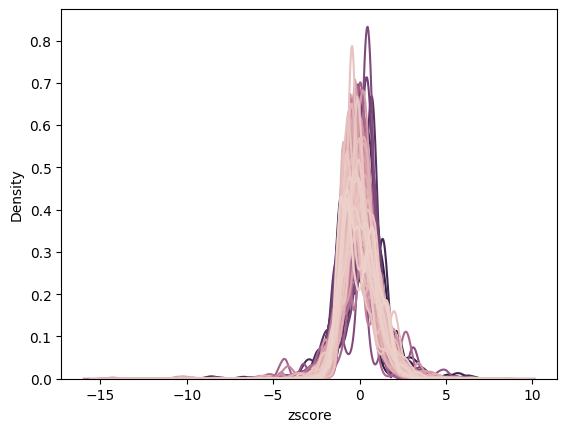

In [51]:
# kdpeplot of zscores
sns.kdeplot(
    data=gdf_properties,
    x='zscore',
    hue='city_cluster',
    legend=False,
    common_norm=False
)


In [52]:
# empties
gdf_properties.iloc[:, -5:].isna().sum()

city_cluster        0
log_terrain_mean    0
log_terrain_std     0
num_properties      0
zscore              0
dtype: int64

In [58]:
# see how many properties are above abs 0f 5
print(gdf_properties['zscore'].abs().gt(5).mean())
print(gdf_properties['zscore'].abs().gt(5).sum())

0.0005915115169049306
505


In [61]:
# see some of the properties
(
    gdf_properties[gdf_properties['zscore'].abs().gt(5)]
    .sort_values('zscore')
    .loc[:, ['property_id', 'zscore', 'land_price_per_sqm', 'price', 'superficie_terreno', 'saleable_area', 'id_tipo_inmueble']]
    )

property_id     zscore  land_price_per_sqm  \
449924  ceda6367e402426daaa94a41b820f9a7 -15.517892                18.690000   
453858  998c7cc1357a42f9a5e1f68334c2510f -15.363719                19.530000   
510504  372cd3254b5649c78f0efa371a725e20 -15.198710                 4.130000   
330161  619c7ba3db484bb88a2660fefb4c51da -14.264695                 1.040000   
555176  c640a24ca0d84dfdb4eeae9e6a94b8fb -14.177193                 0.310000   
...                                  ...        ...                      ...   
189089  2b9ad6e84051441f89d684170495b509   8.240850             16365.055762   
261545  e790c4236d4049829e494af5ee3811cf   8.420616            248709.900000   
832678  c4c7905870364bbaa08c0480172e3249   8.466413            121600.000000   
2467    6dd74639a6de4c1a81aaee2cb72d88bb   9.655969            328899.000000   
553627  cfb24260a16e4ea690f4890f3c1a62da   9.725381            137600.390000   

        price  superficie_terreno  saleable_area  \
449924                 367000                   1                   47   
453858                 374000                   1                   47   
510504                1370000                 109                  100   
330161                 573000                  37                   54   
555176                 746000                   9                   87   
...                       ...                 ...                  ...   
189089                7021000                 269                  212   
261545                4001000                   3                  105   
832678                5080000                   4                  139   
2467                  1850000                 102                   87   
553627                 573000                  97                   55   

        id_tipo_inmueble  
449924                 3  
453858                 3  
510504                 2  
330161                 4  
555176                 4  
...                  ...  
189089                 2  
261545                 4  
832678                 4  
2467                   3  
553627                 3  

[505 rows x 7 columns]

In [62]:
# drop outliers
gdf_properties = gdf_properties[gdf_properties['zscore'].abs().le(5)]
gdf_properties.shape

(853240, 56)

## S4: Price Validation by Hexagons

In [63]:
def latlon_to_h3(latitudes, longitudes, resolution):
    """
    Convert latitude and longitude arrays to H3 hexagon IDs at a given resolution.
    
    Parameters:
    - latitudes: numpy array of latitudes
    - longitudes: numpy array of longitudes
    - resolution: H3 resolution
    
    Returns:
    - numpy array of H3 hexagon IDs
    """
    # Ensure inputs are numpy arrays
    latitudes = np.asarray(latitudes)
    longitudes = np.asarray(longitudes)
    
    # Check that latitudes and longitudes are the same shape
    if latitudes.shape != longitudes.shape:
        raise ValueError("Latitudes and longitudes must be the same shape")
    
    # Vectorize the h3 function
    vectorized_h3 = np.vectorize(h3.geo_to_h3)
    
    # Apply the function to the latitude and longitude arrays
    hex_ids = vectorized_h3(latitudes, longitudes, resolution)
    
    return hex_ids

# crs to 4326
gdf_properties = gdf_properties.to_crs('EPSG:4326')
gdf_properties['longitude'] = gdf_properties.geometry.x
gdf_properties['latitude'] = gdf_properties.geometry.y

# get hex id
gdf_properties['hex_id'] = latlon_to_h3(
    gdf_properties['latitude'],
    gdf_properties['longitude'],
    resolution=7
)

In [64]:
# zscores by hex_id
table_zscores_hex = (
    gdf_properties
    .assign(
        price_per_sqm=lambda x: x['price'] / x['saleable_area'],
        log_price_per_sqm=lambda x: np.log(x['price_per_sqm'])
    )
    .groupby('hex_id', as_index=False)
    .agg(
        log_price_per_sqm_mean=('log_price_per_sqm', 'mean'),
        log_price_per_sqm_std=('log_price_per_sqm', 'std'),
        num_properties=('property_id', 'count')
    )
    .sort_values('log_price_per_sqm_std')
    .query('num_properties > 2')  # at least 3 properties
    # get polygon
    .assign(
        geometry=lambda x: x['hex_id'].apply(lambda h: Polygon(h3.h3_to_geo_boundary(h, geo_json=True)))
    )
    # create geodataframe
    .pipe(gpd.GeoDataFrame)
    .set_crs('EPSG:4326')
)
table_zscores_hex

hex_id  log_price_per_sqm_mean  log_price_per_sqm_std  \
2396  87499589affffff                9.545489               0.000000   
1141  8748a23aeffffff                9.576774               0.005229   
1509  8749814f0ffffff                9.535534               0.005670   
1860  874988cb2ffffff                9.734747               0.011584   
1821  8749867a2ffffff                9.266394               0.013581   
...               ...                     ...                    ...   
1174  8748a2a92ffffff               10.243458               0.708500   
2839  8749a9668ffffff               10.333374               0.734454   
219   87456da06ffffff                9.852974               0.742678   
2837  8749a9661ffffff               10.325531               0.763833   
165   87450a694ffffff                9.792509               0.842229   

      num_properties                                           geometry  
2396               4  POLYGON ((-98.80693 19.31362, -98.79823 19.324...  
1141               9  POLYGON ((-100.38846 25.85709, -100.37939 25.8...  
1509              10  POLYGON ((-101.40288 20.62754, -101.39423 20.6...  
1860               3  POLYGON ((-102.31962 21.98619, -102.31093 21.9...  
1821               4  POLYGON ((-99.60413 19.36157, -99.59547 19.372...  
...              ...                                                ...  
1174             346  POLYGON ((-100.43678 25.65756, -100.42772 25.6...  
2839             102  POLYGON ((-105.24330 20.64484, -105.23490 20.6...  
219                3  POLYGON ((-97.80288 22.29470, -97.79394 22.305...  
2837              42  POLYGON ((-105.22422 20.60739, -105.21582 20.6...  
165              118  POLYGON ((-86.81468 21.16865, -86.80574 21.178...  

[3183 rows x 5 columns]

In [65]:
# plot mean
table_zscores_hex.query("num_properties > 1").explore(column='log_price_per_sqm_std', legend=True, cmap='magma', tiles='CartoDB positron')

In [66]:
# plot mean
table_zscores_hex.query("num_properties > 1").explore(column='log_price_per_sqm_mean', legend=True, tiles='CartoDB positron')

In [67]:
# normalize
gdf_properties = (
    gdf_properties
    .assign(
        price_per_sqm=lambda x: x['price'] / x['saleable_area'],
        log_price_per_sqm=lambda x: np.log(x['price_per_sqm'])
    )
    .merge(
        table_zscores_hex,
        how='inner',
        on='hex_id'
    )
    .assign(
        zscore_ppm2=lambda x: (x['log_price_per_sqm'] - x['log_price_per_sqm_mean']) / x['log_price_per_sqm_std']
    )
)
gdf_properties

property_id  valor_fisico_construccion  \
0       66cf10199ef943a5a5ff82129e53d5d7                 1611371.52   
1       f84f9a0c784f491eab6bb100b513a95b                  460588.28   
2       7ddd5a94feed4955a809f986d95722d8                 1029107.14   
3       d2e75fb3b385461995bf8d34b9d1fdfb                  598308.77   
4       6f1194f9853443219e63f4a3222b010e                  144720.00   
...                                  ...                        ...   
853028  3df99182d51044d08a35cf11de20dc04                  380094.00   
853029  27774d8b8fd94d74ab3aa47569a5de07                  996696.00   
853030  abdf8341fb43426faf32c4baf2ff22eb                  996696.00   
853031  5d2874d128bf4ccca781e500a80bc063                  415048.80   
853032  24d6f259256d4f0a833ace02c926339e                  455100.00   

                property_id valuation_date                         neighborhood  \
0       090682009R0225150   2020-05-27                              SD   
1       090682015R0258032   2020-07-23                              SD   
2       090762015R0043870   2020-10-05                              SD   
3       090832009R0615780   2020-10-22                              SD   
4       090682015R0226052   2020-05-27                              SD   
...                   ...          ...                             ...   
853028  31003233110081800   2023-12-14  FRACCIONAMIENTO DESPERTARE RES   
853029  31003233110081800   2023-12-14            FRACC SERAPIO RENDON   
853030  31003233110082000   2023-12-15            FRACC SERAPIO RENDON   
853031  31003233110082000   2023-12-19               PLAN DE AYALA SUR   
853032  31003233110082000   2023-12-18  FRACCIONAMIENTO BICENTENARIO L   

        id_clase_inmueble  id_tipo_inmueble  conservacion  elevador  niveles  \
0                       4                 2           4.0       1.0        4   
1                       3                 2           4.0       2.0        3   
2                       4                 2           4.0       2.0        1   
3                       4                 2           4.0       2.0        2   
4                       4                 2           4.0       2.0        1   
...                   ...               ...           ...       ...      ...   
853028                  4                 3           6.0       2.0        1   
853029                  4                 2           4.0       2.0        2   
853030                  4                 2           4.0       2.0        2   
853031                  2                 2           4.0       2.0        1   
853032                  4                 2           6.0       2.0        1   

        cve_ref_proximidad_urbana  cve_nivel_equipamiento_urbano  \
0                               1                              1   
1                               2                              1   
2                               2                              1   
3                               2                              1   
4                               3                              1   
...                           ...                            ...   
853028                          3                              4   
853029                          2                              4   
853030                          2                              4   
853031                          3                              4   
853032                          3                              4   

        valor_mercado  price  nivel unidades_rentables  \
0             4305275                4305000      3                  1   
1             1351682                1352000      3                  1   
2             2544900                2545000      0                  1   
3             2906000                2906000      3                  1   
4              535697                 536000      3                  1   
...               ...                    ...    ...                ...  

/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset =

<Axes: xlabel='zscore_ppm2', ylabel='Density'>

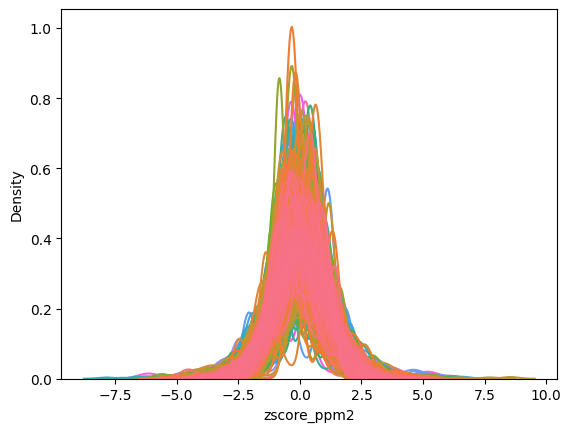

In [68]:
# kdpeplot of zscores
sns.kdeplot(
    data=gdf_properties,
    x='zscore_ppm2',
    hue='hex_id',
    legend=False,
    common_norm=False,
    color='C0'
)


In [71]:
# how many properties are above abs 0f 5
print(gdf_properties['zscore_ppm2'].abs().gt(5).mean())
print(gdf_properties['zscore_ppm2'].abs().gt(5).sum())

0.0001148841838475182
98


In [76]:
# see some of the properties
(
    gdf_properties[gdf_properties['zscore_ppm2'].abs().gt(5)].sort_values('zscore_ppm2')
    .loc[:, ['property_id', 'log_price_per_sqm_mean',  'log_price_per_sqm_std', 'zscore_ppm2', 'log_price_per_sqm', 'price_per_sqm', 'price', 'saleable_area', 'id_tipo_inmueble']]
    )

property_id  log_price_per_sqm_mean  \
548196  57bed2a8b9444599bb8030cab7ef362f                9.892569   
501863  1b93d55a1ac34d8f982ed17108891822                9.761441   
587049  b1d11d4df2dc4f31badd18b750b7a310                9.241470   
161646  ba44cc5f8bb8457cb22365b5a27e903a               10.069434   
532667  4d4781300db64edab3897e41c21191d7                9.369972   
...                                  ...                     ...   
595872  9c20d39c333349d3bb351ef8cdd3e75a                9.196283   
227856  bbcb9684c9a64088b8cae54143f5b729                9.117650   
319777  3cecfe0d399c496da64ed427721f3f4e                9.763103   
228784  8b93e22ed88645178431dd0005d755ff                9.512444   
520709  2cc33212c95342f0b8c9222896b3b549               10.400790   

        log_price_per_sqm_std  zscore_ppm2  log_price_per_sqm  price_per_sqm  \
548196               0.123242    -7.849687           8.925155    7518.750000   
501863               0.164584    -7.187211           8.578538    5316.326531   
587049               0.071059    -6.537775           8.776901    6482.758621   
161646               0.217556    -6.207022           8.719059    6118.421053   
532667               0.099354    -6.150501           8.758898    6367.088608   
...                       ...          ...                ...            ...   
595872               0.148601     6.591088          10.175728   26258.064516   
227856               0.212247     6.980678          10.599275   40105.769231   
319777               0.149530     7.688188          10.912714   54869.565217   
228784               0.216571     7.996656          11.244292   76442.307692   
520709               0.161634     8.535094          11.780349  130659.420290   

        price  saleable_area  id_tipo_inmueble  
548196                1203000                  160                 2  
501863                 521000                   98                 2  
587049                 376000                   58                 2  
161646                 930000                  152                 2  
532667                1006000                  158                 2  
...                       ...                  ...               ...  
595872                8140000                  310                 2  
227856                4171000                  104                 2  
319777                6310000                  115                 4  
228784                7950000                  104                 2  
520709               18031000                  138                 3  

[98 rows x 9 columns]

In [77]:
# drop outliers
gdf_properties = gdf_properties[gdf_properties['zscore_ppm2'].abs().le(5)]

In [78]:
# shape
gdf_properties.shape

(852931, 64)

---
# Save

In [84]:
# save
(
    gdf_properties
    .rename(columns={'longitude': 'longitude', 'latitude': 'latitude'})
    .loc[:, original_columns]
    .to_parquet("../../data/interim/cleaned_data_s4.parquet")
    )